In [1]:
import numpy as np
import torch
from pathlib import Path
import os
from bnn_priors.models import RaoBDenseNet
import matplotlib.pyplot as plt

from pyro.infer.mcmc import NUTS, HMC
from pyro.infer.mcmc.api import MCMC

In [2]:
data = np.load("../data/snelson.npz")

model = RaoBDenseNet(1, 1, 100, output_std=0.3)
if torch.cuda.is_available():
    model = model.cuda()

x_train = torch.from_numpy(data['x_train']).unsqueeze(1).to(model.lin1.weight)
y_train = torch.from_numpy(data['y_train']).unsqueeze(1).to(x_train)

x_test = torch.from_numpy(data['x_test']).unsqueeze(1).to(x_train)

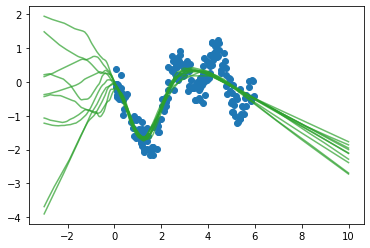

In [3]:
for _ in range(10):
    model.sample_all_priors()
    with torch.no_grad():
        plt.plot(x_test.cpu(), model(x_test, x_train=x_train, y_train=y_train).loc.cpu(), color="C2", alpha=0.7)
plt.scatter(x_train.cpu(), y_train.cpu())
plt.show()

In [17]:
N_steps = 200
warmup = 1000

kernel = HMC(potential_fn=model.get_potential(x_train, y_train),
             adapt_step_size=False, adapt_mass_matrix=False,
             step_size=2e-3, num_steps=32)
mcmc = MCMC(kernel, num_samples=N_steps, warmup_steps=warmup, initial_params = model.params_with_prior_dict())
mcmc.run(x=x_train, y=y_train)

samples = mcmc.get_samples()

Sample: 100%|██████████| 1200/1200 [03:23,  5.90it/s, step size=2.00e-03, acc. prob=0.112]


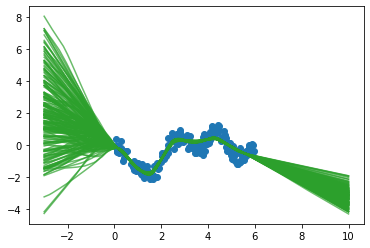

In [18]:
for i in range(N_steps):
    sample = dict((k, v[i]) for k, v in samples.items())
    with torch.no_grad(), model.using_params(sample):
        plt.plot(x_test.cpu(), model(x_test, x_train=x_train, y_train=y_train).loc.cpu(), color="C2", alpha=0.7)
plt.scatter(x_train.cpu(), y_train.cpu())
plt.show()